In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import wedjat.wedjat as wj
import sesh.dnn.ptah_net as infer

In [2]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

test_dir = '../wedjat/test/'
template_dir = '../ptah/template_images/'

| Number of registers identified:  6
| Number of clean registers: 6


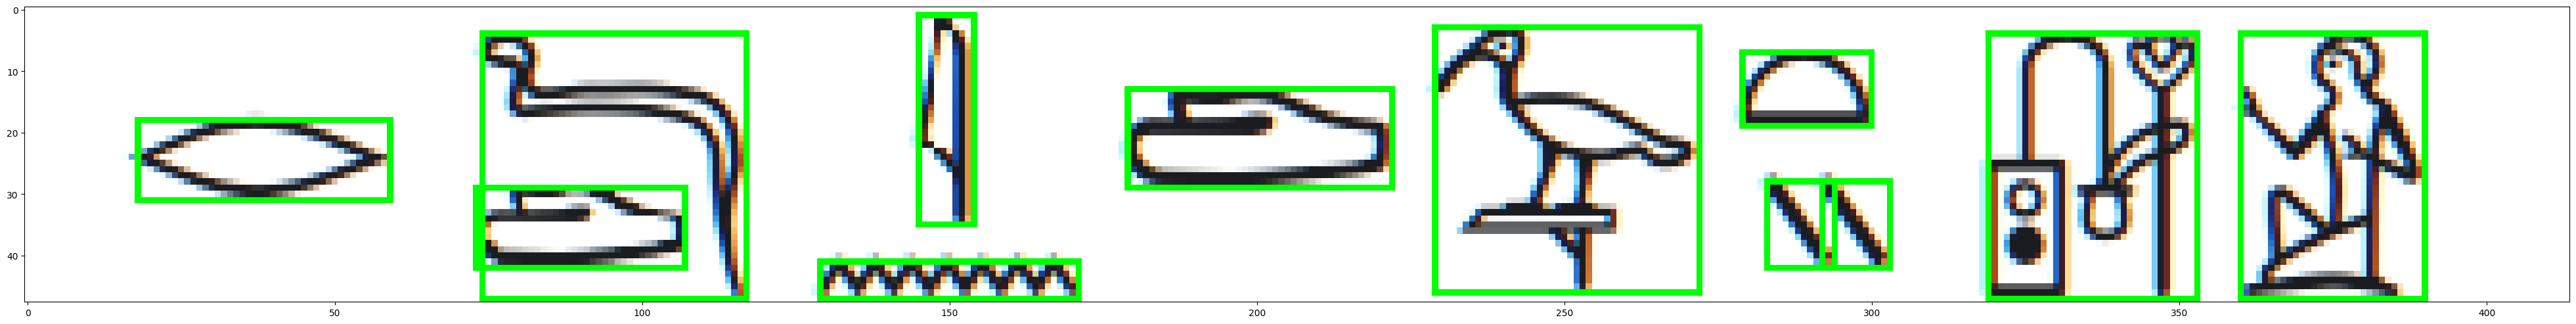

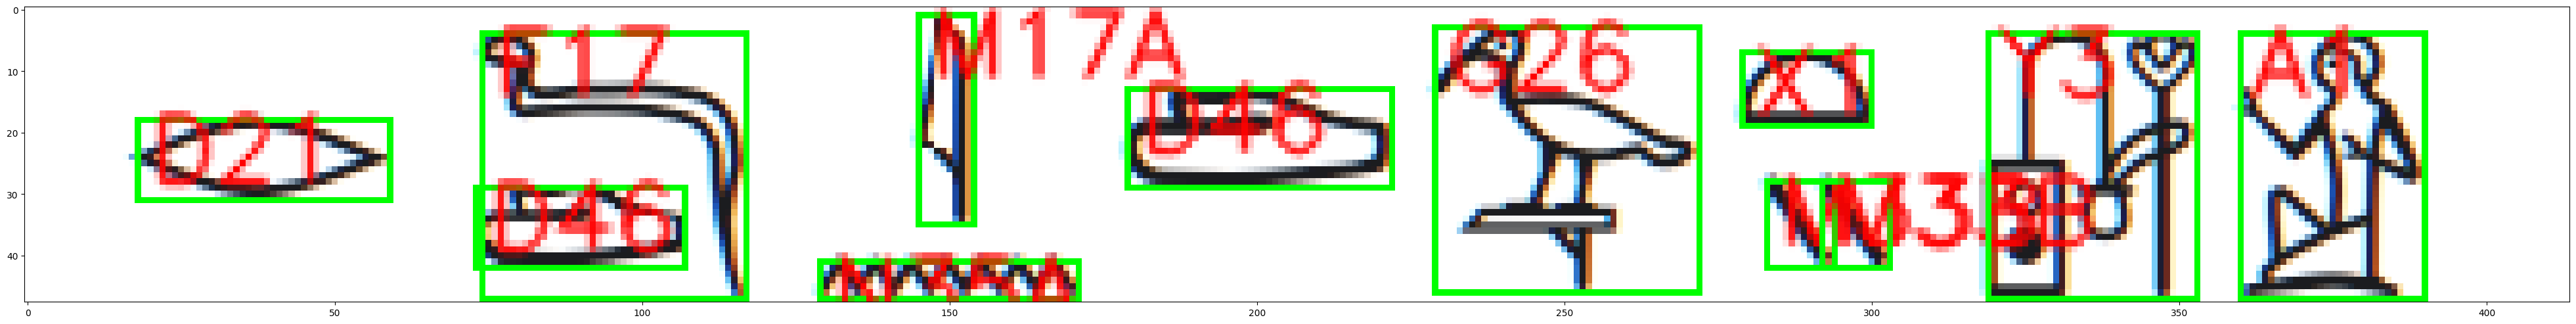

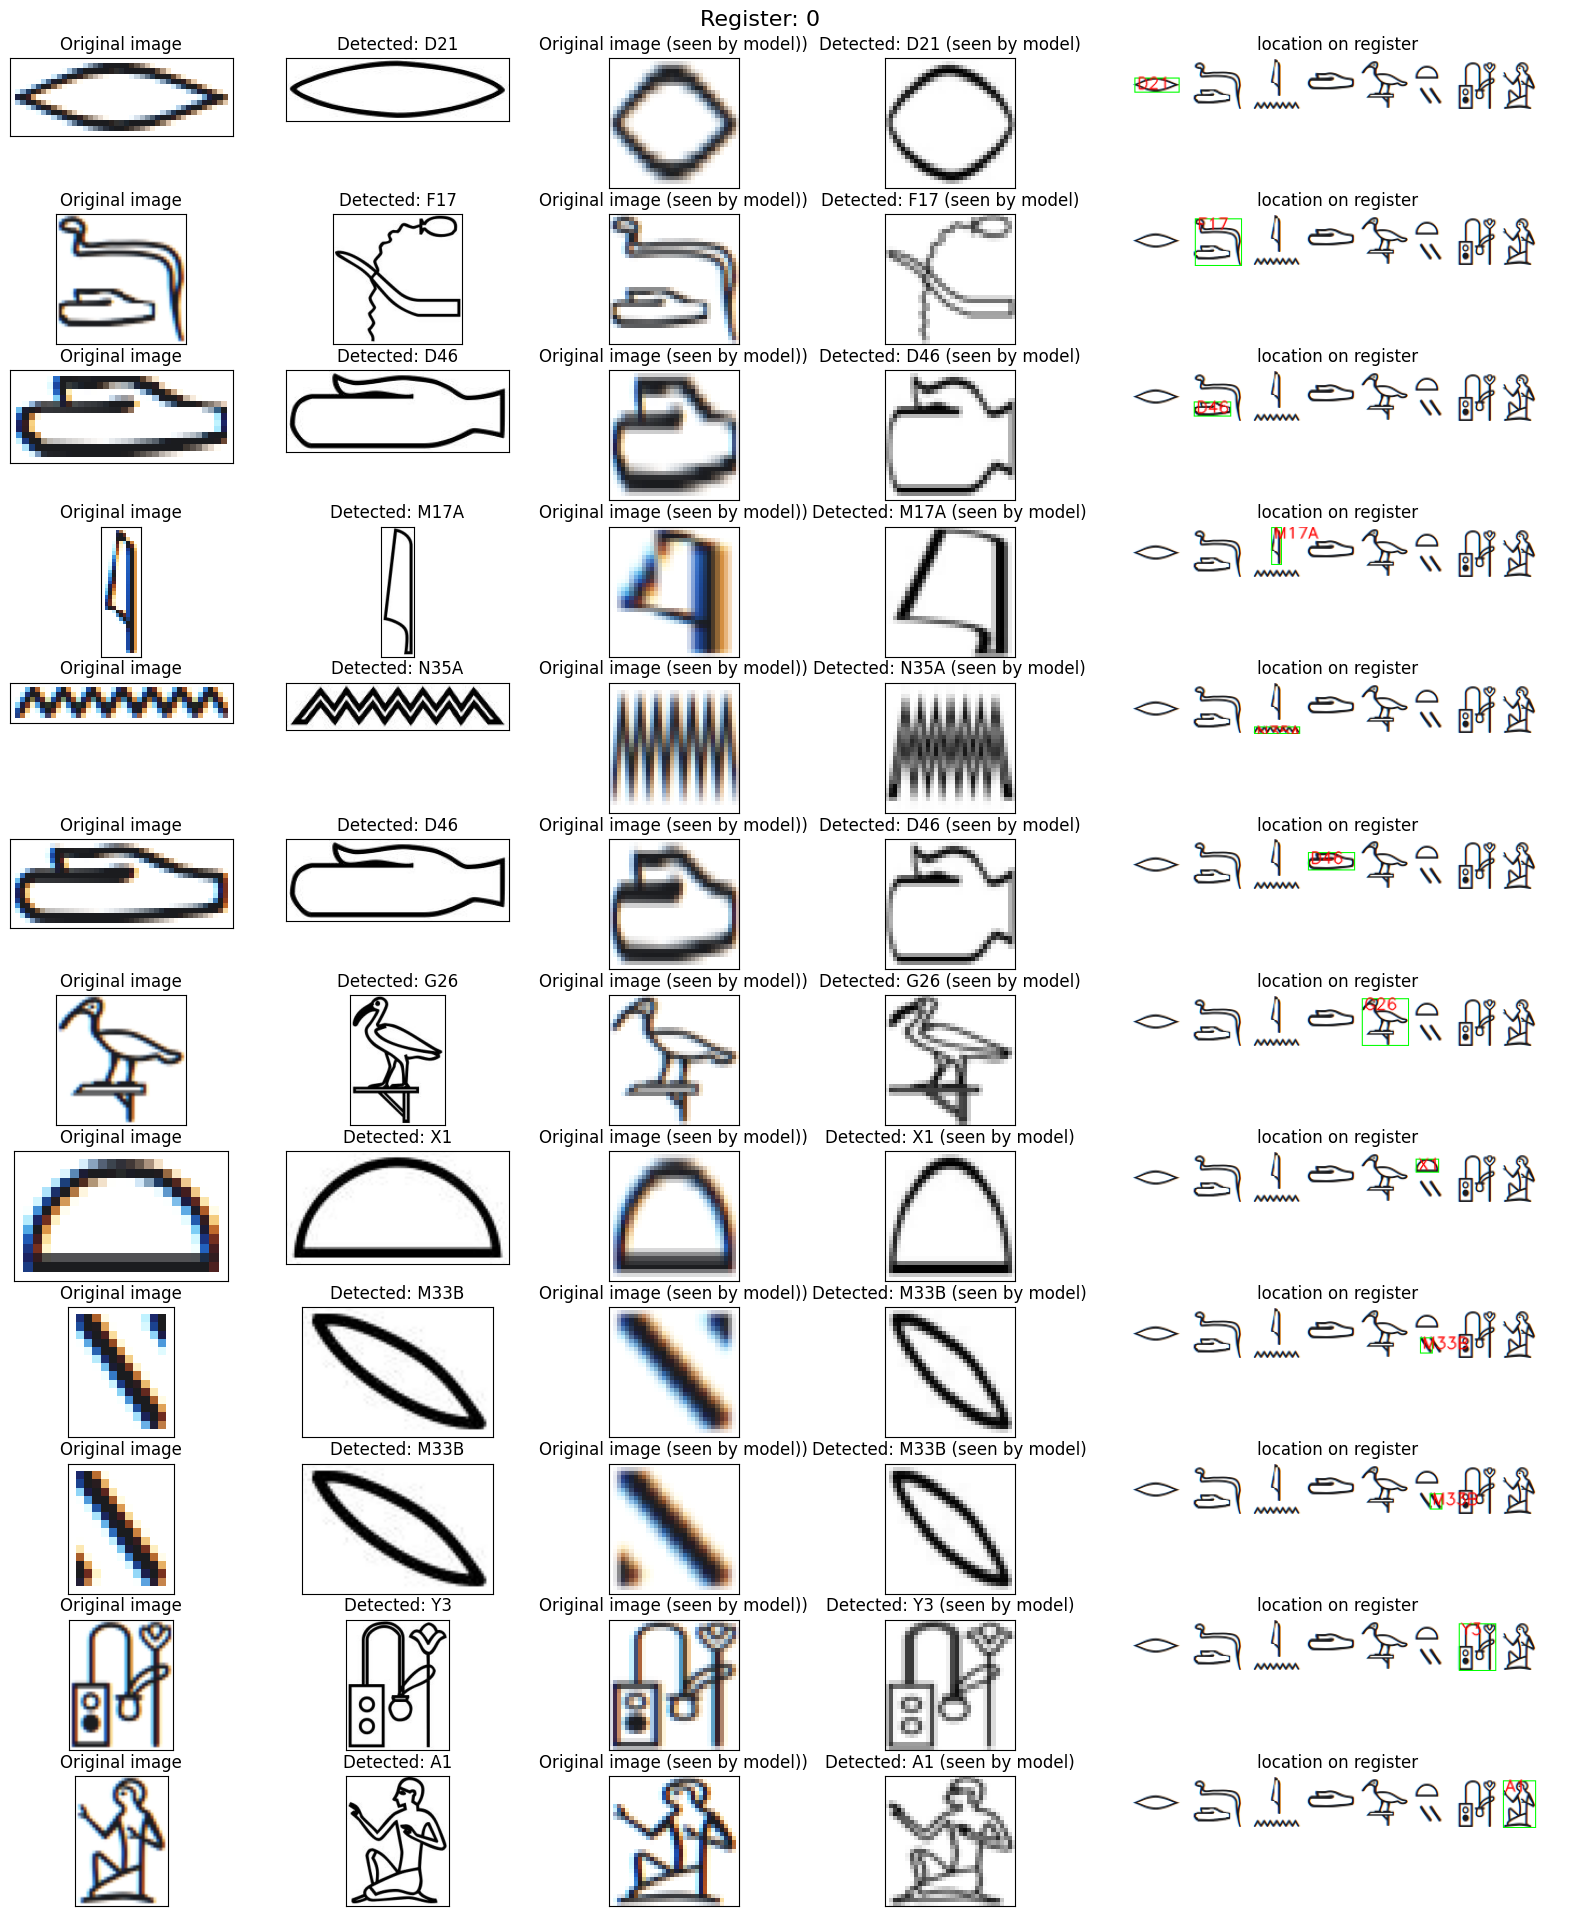

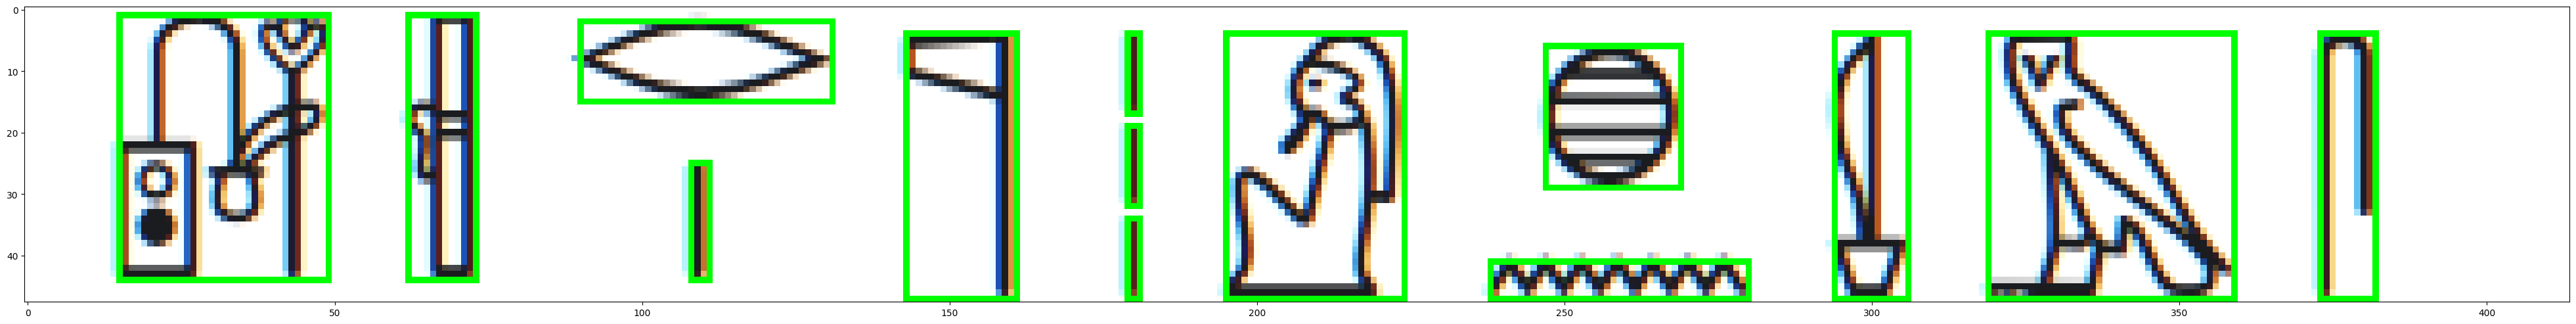

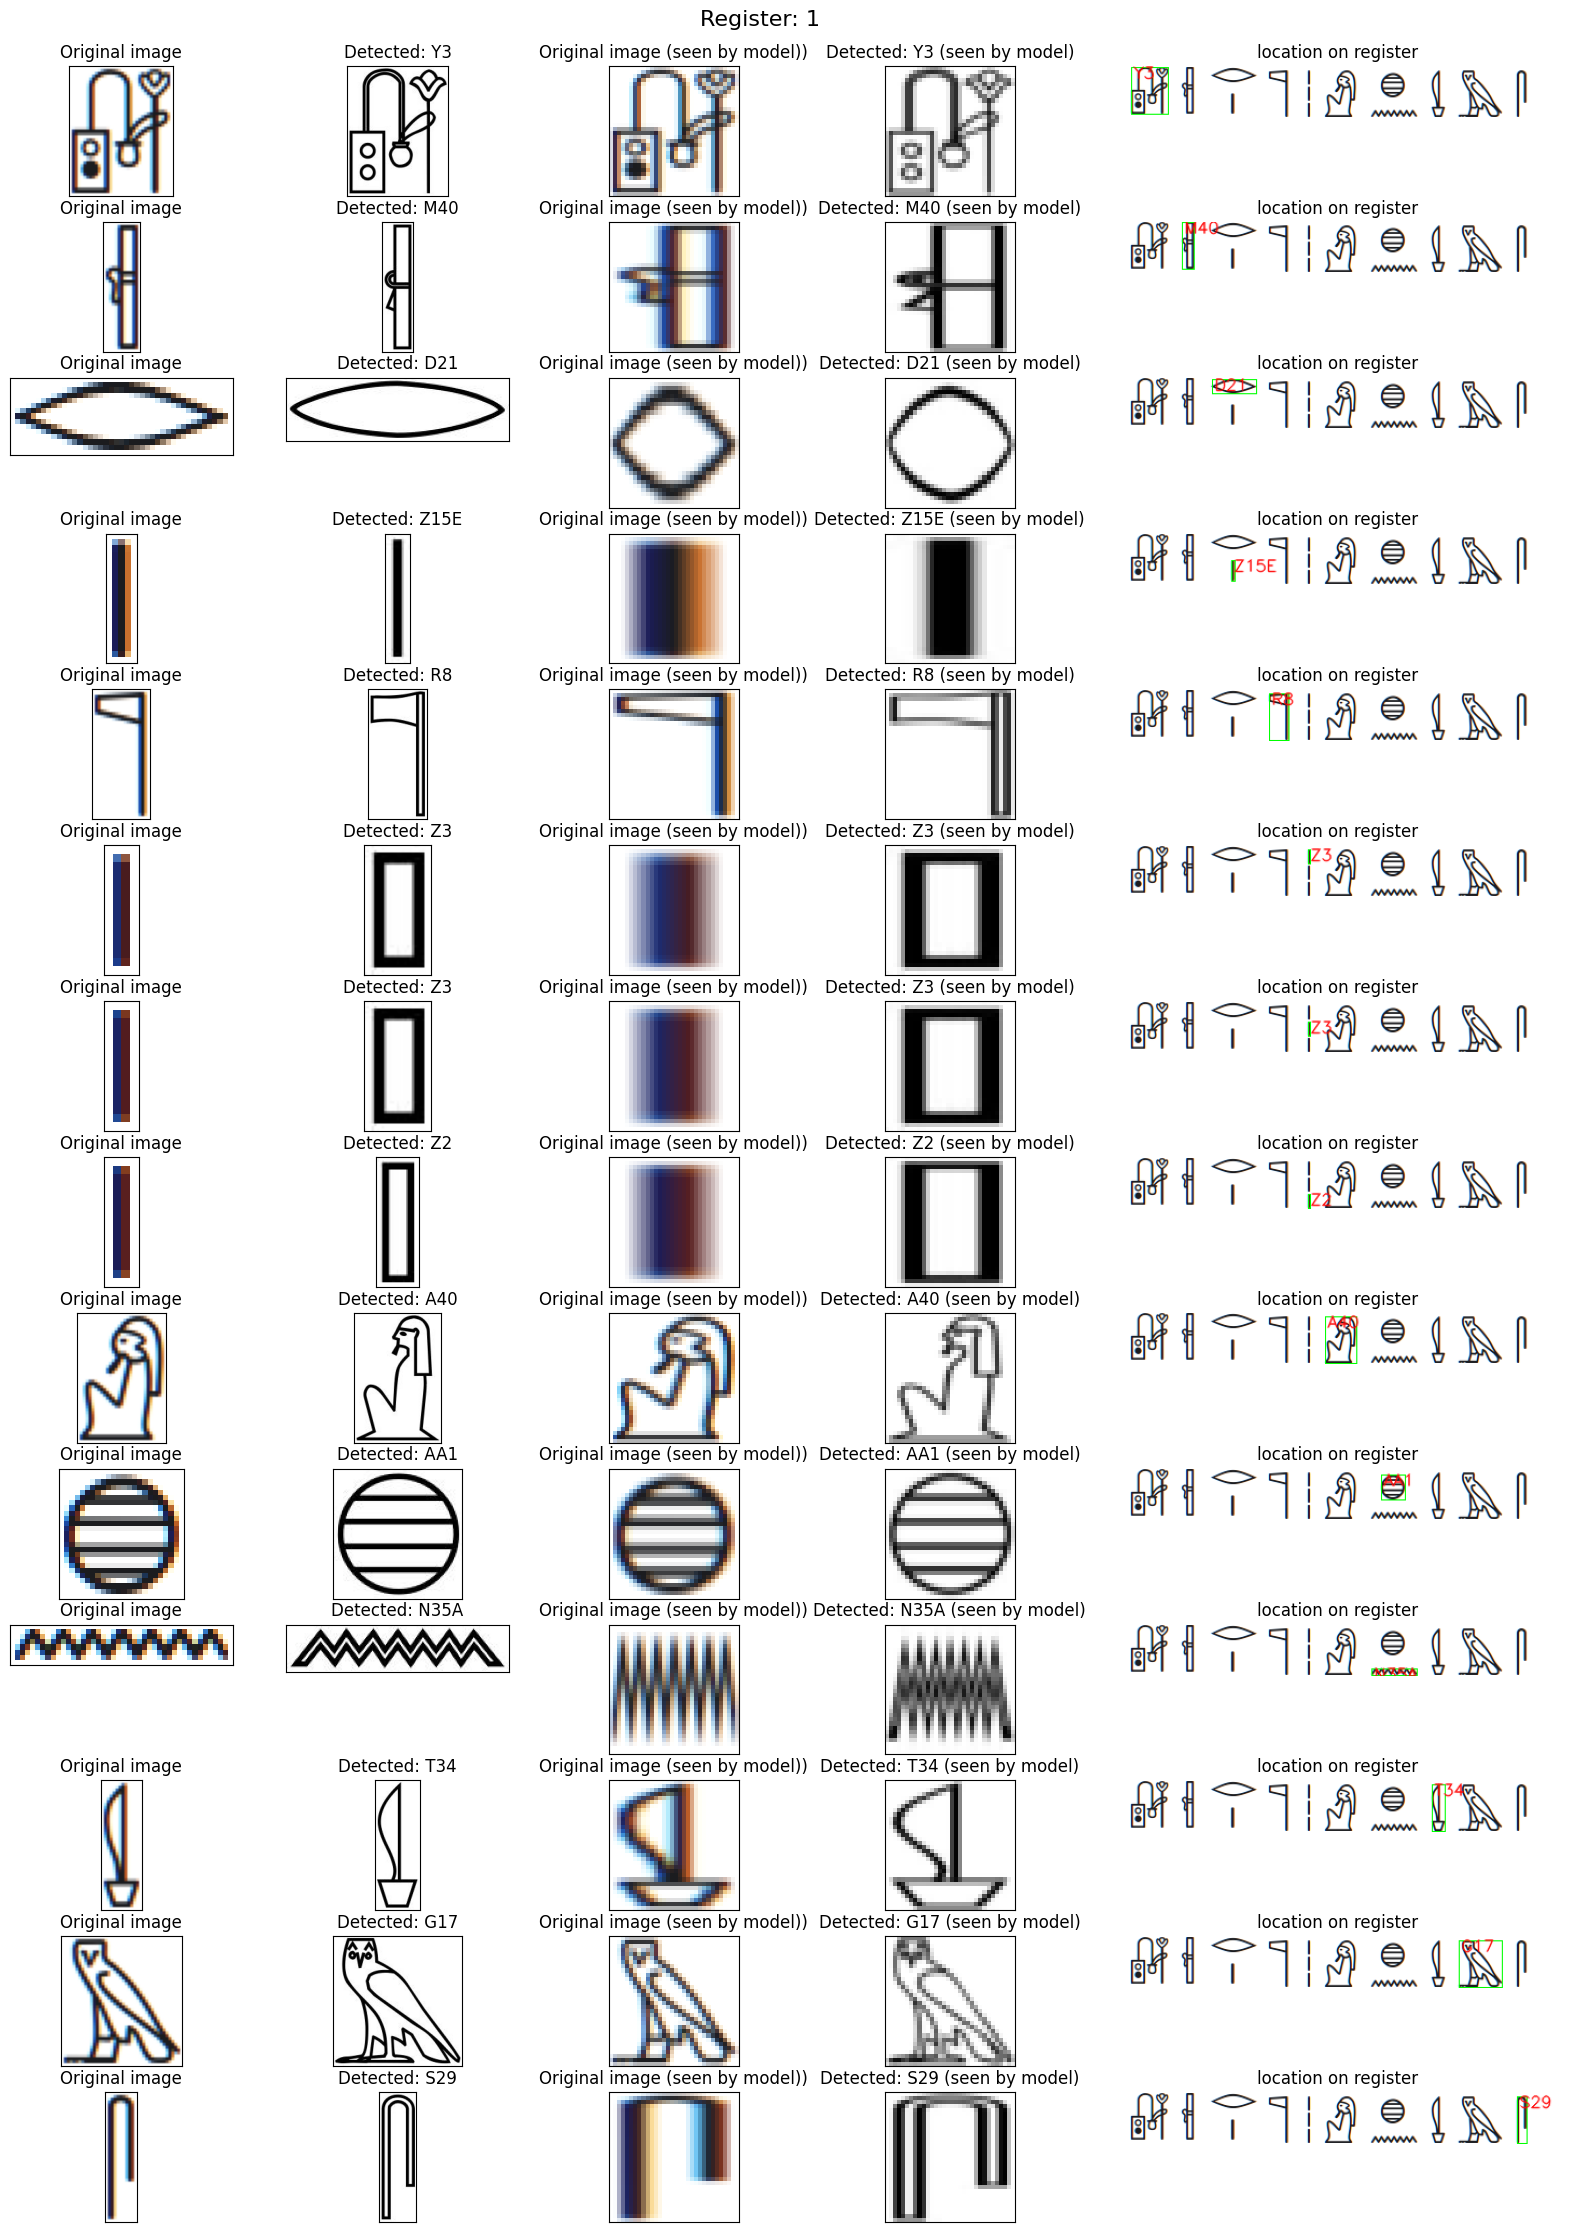

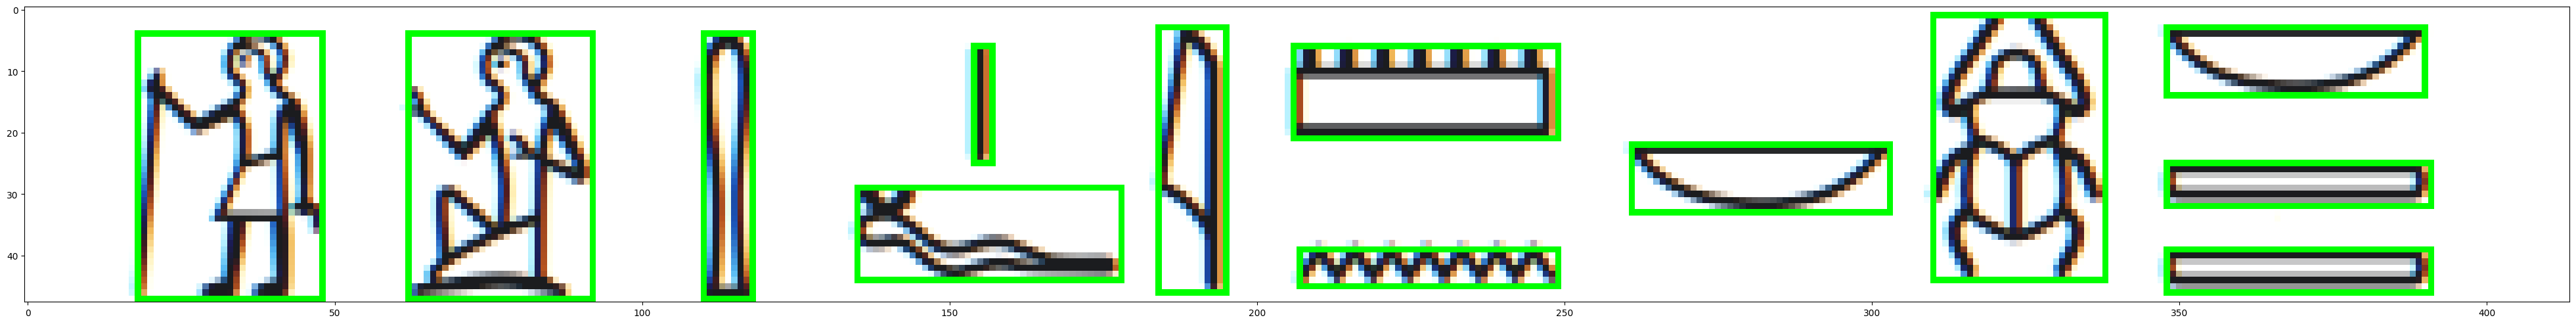

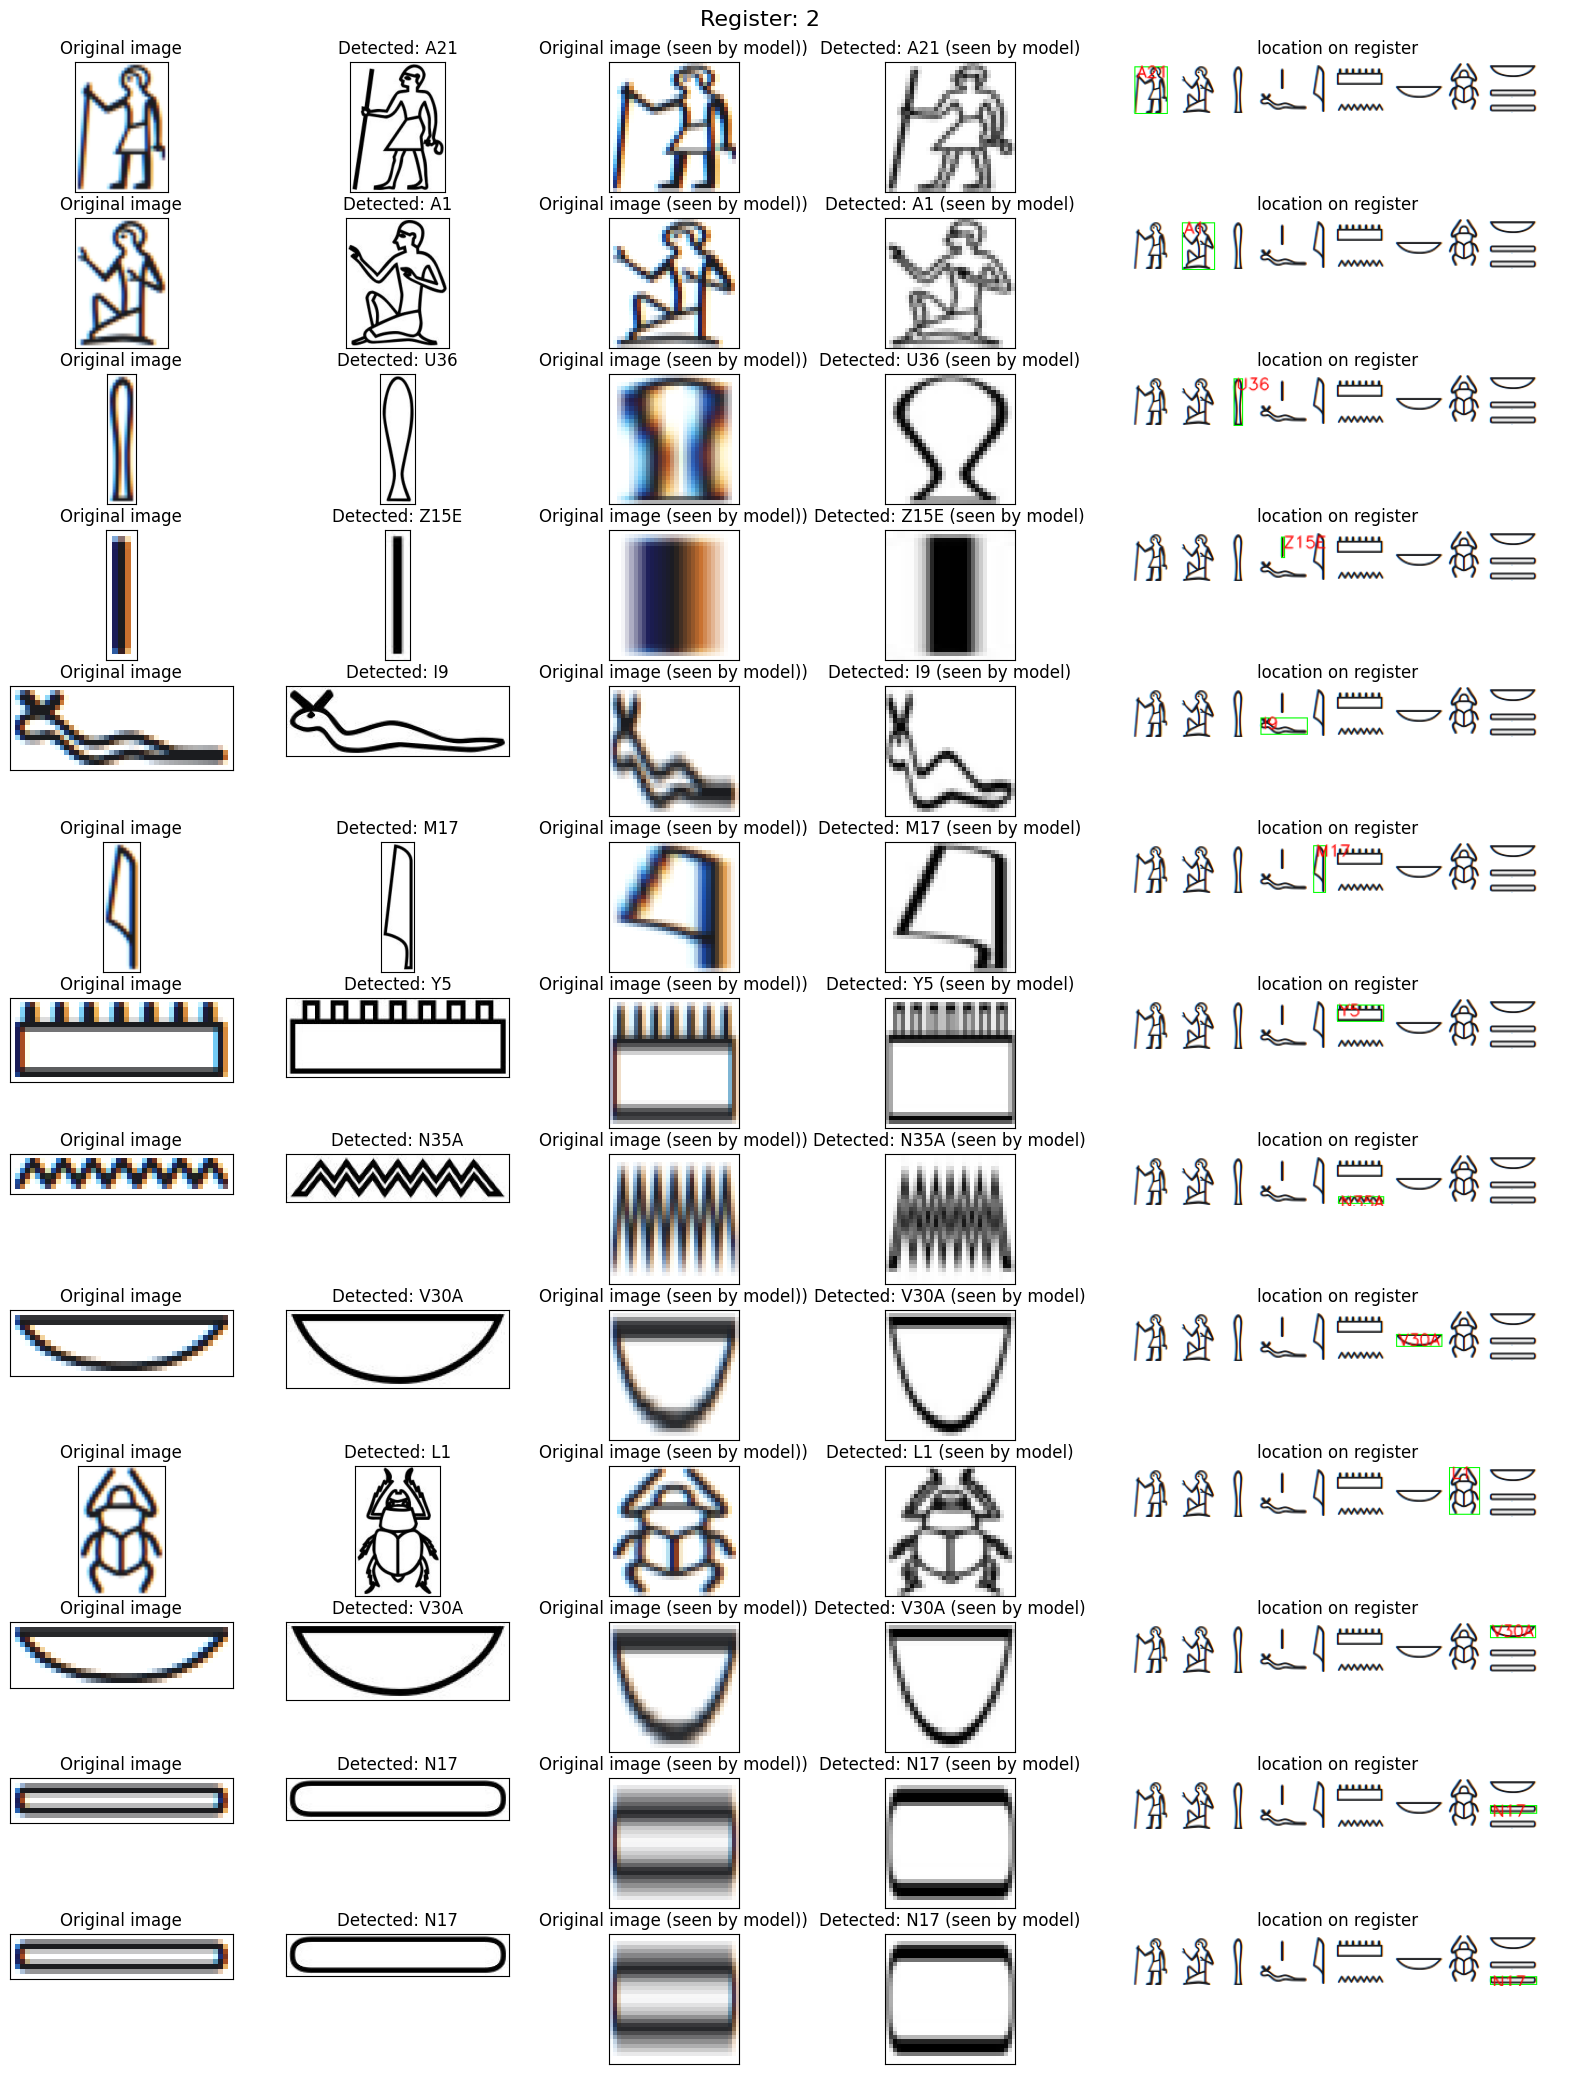

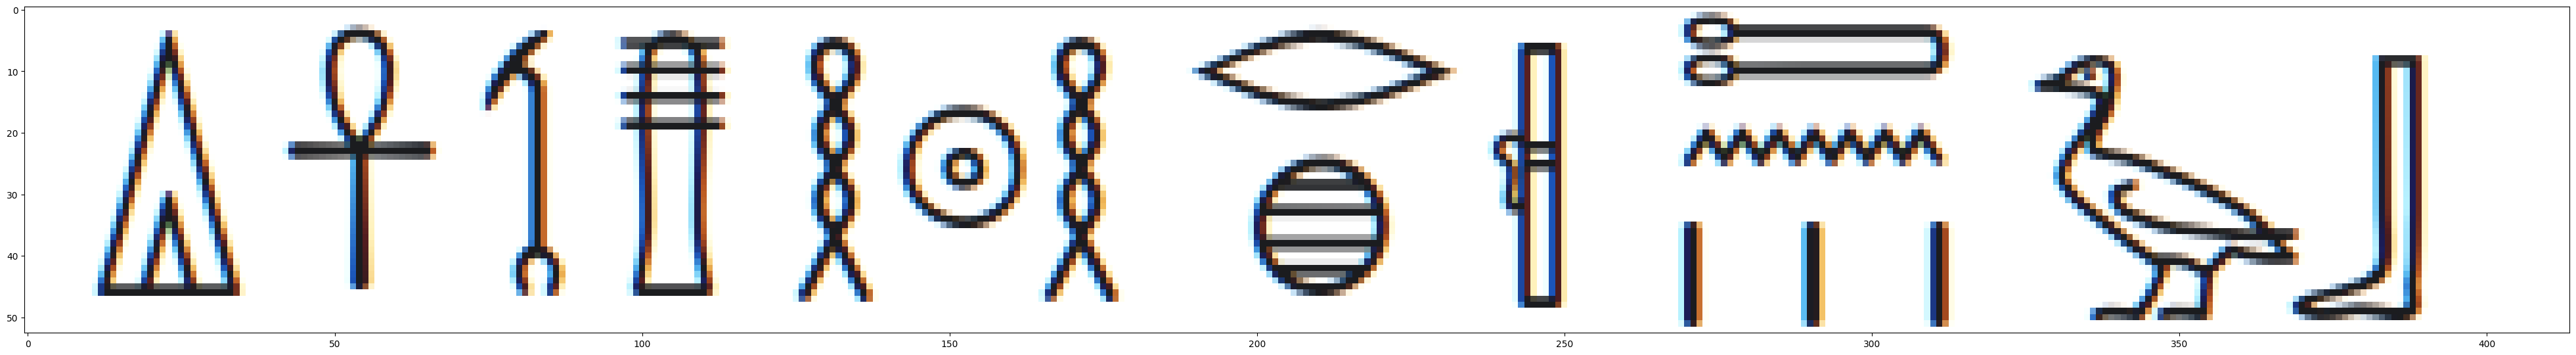

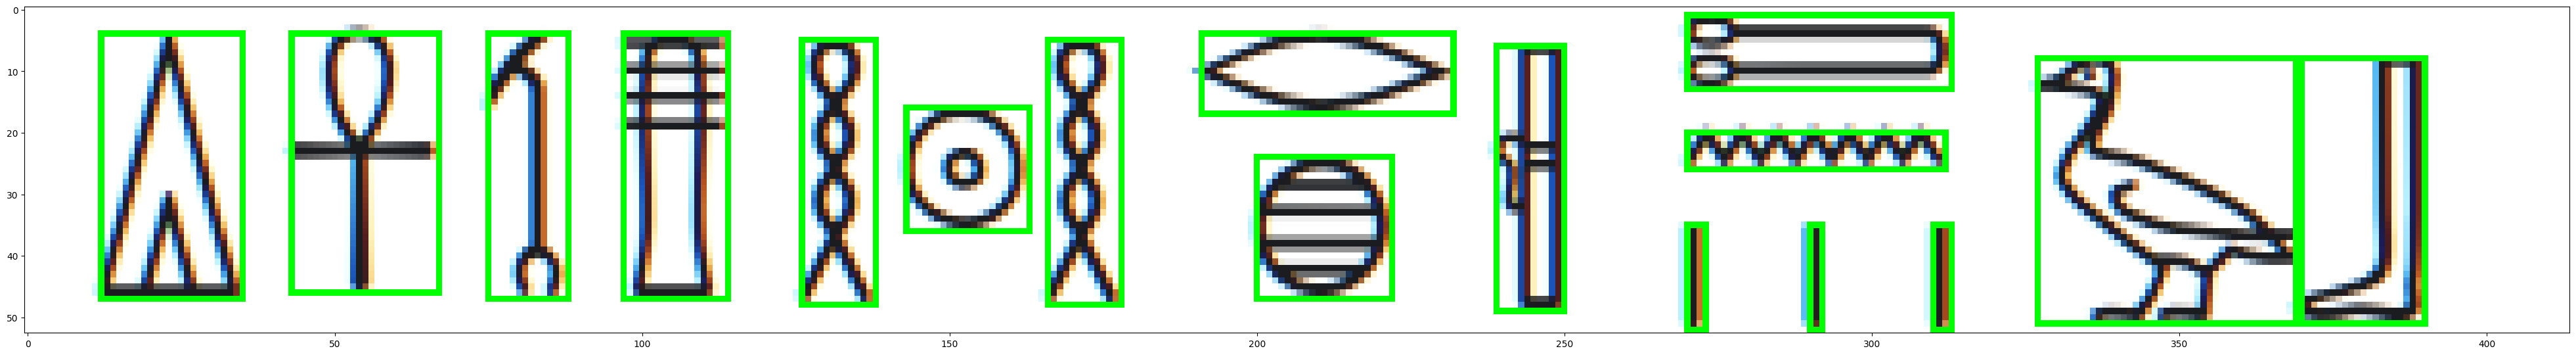

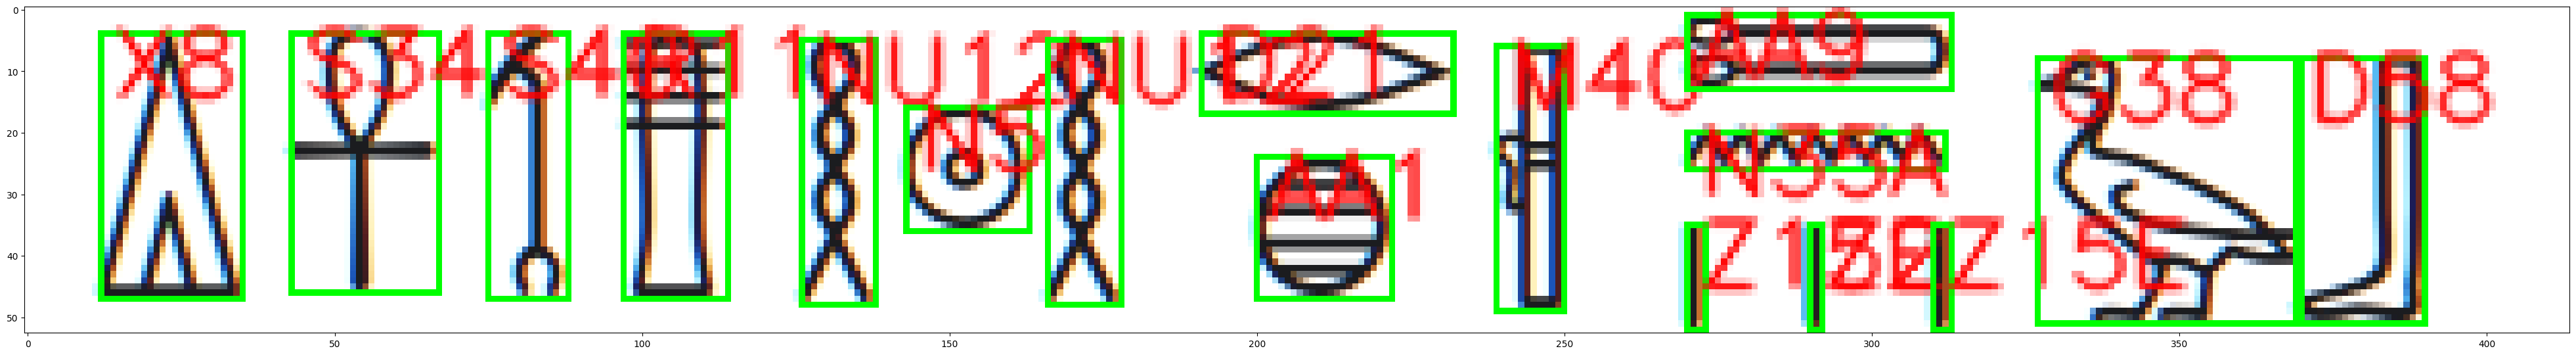

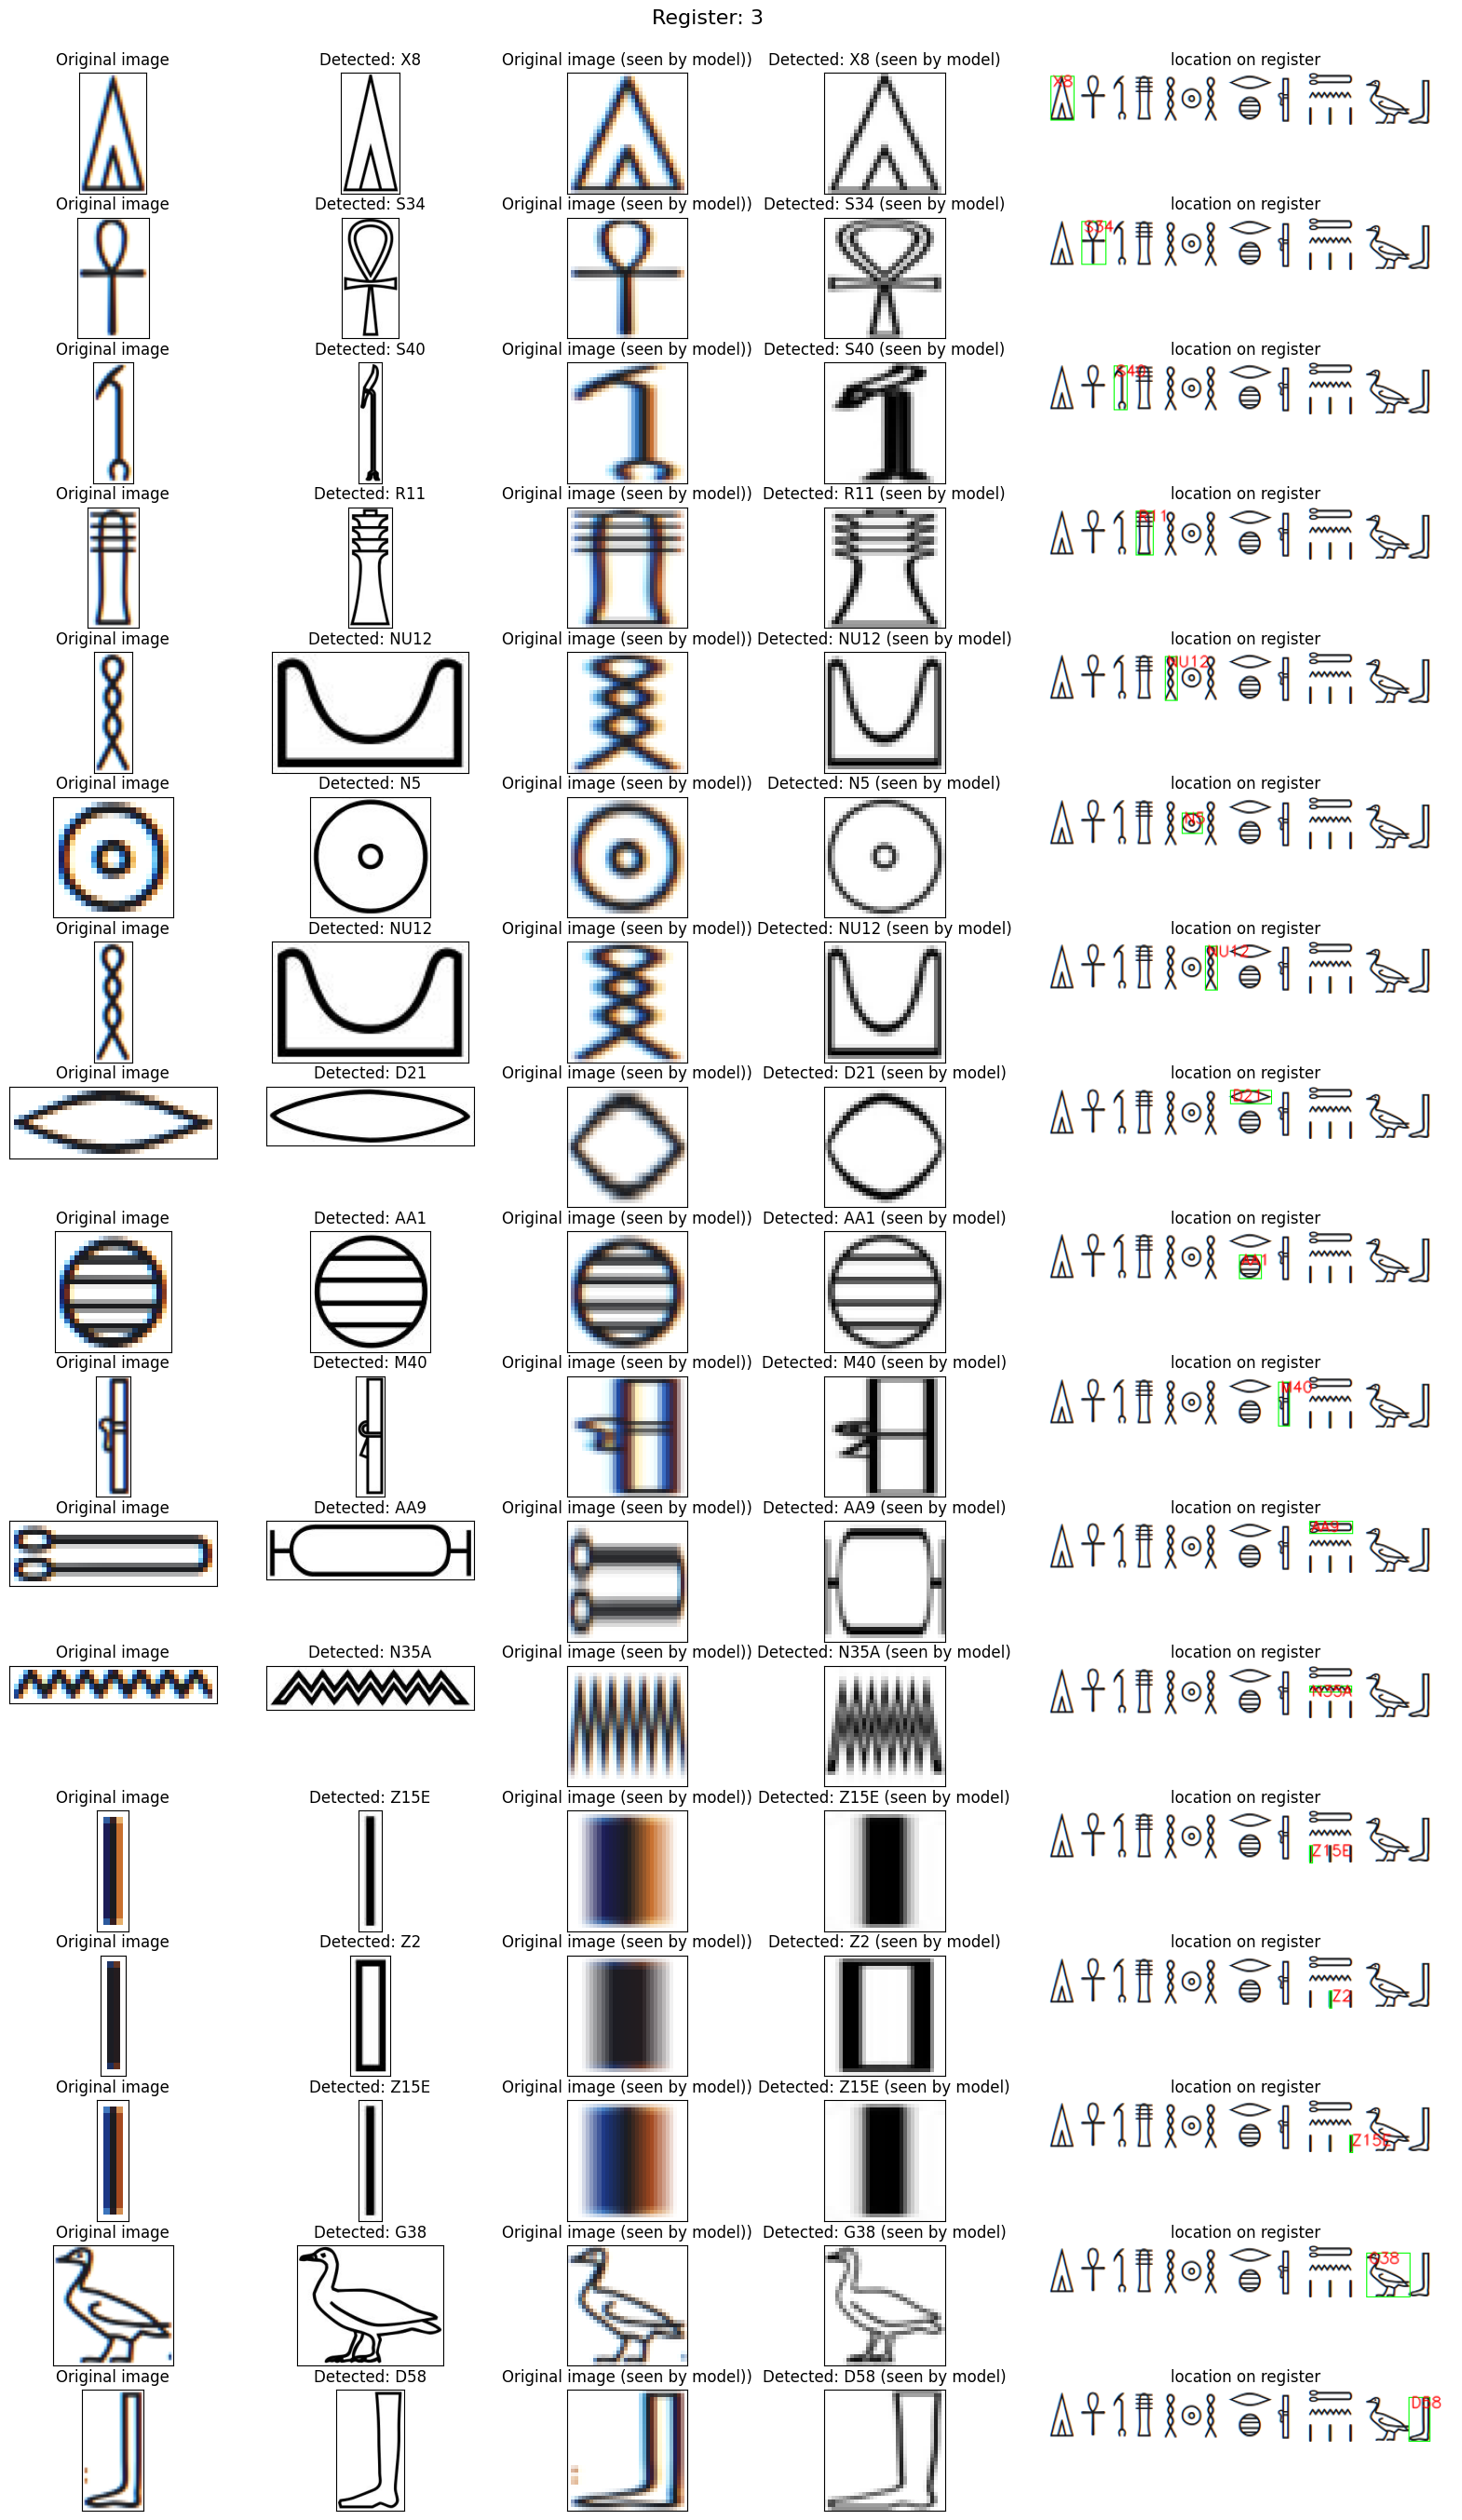

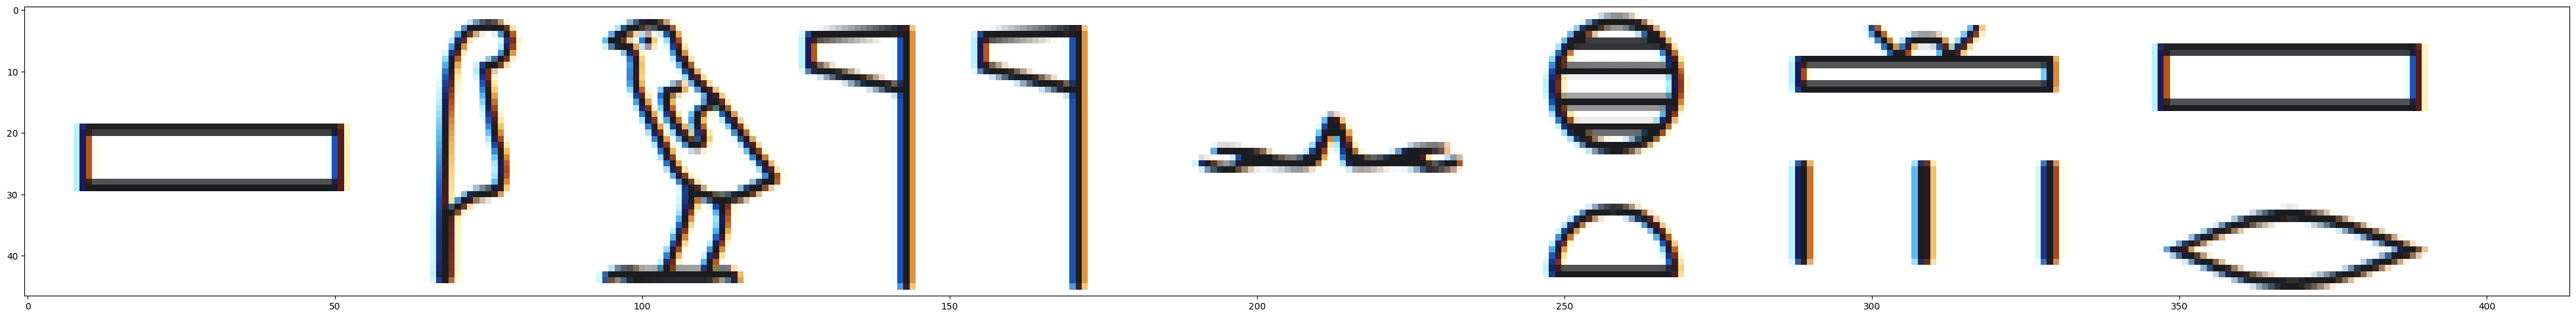

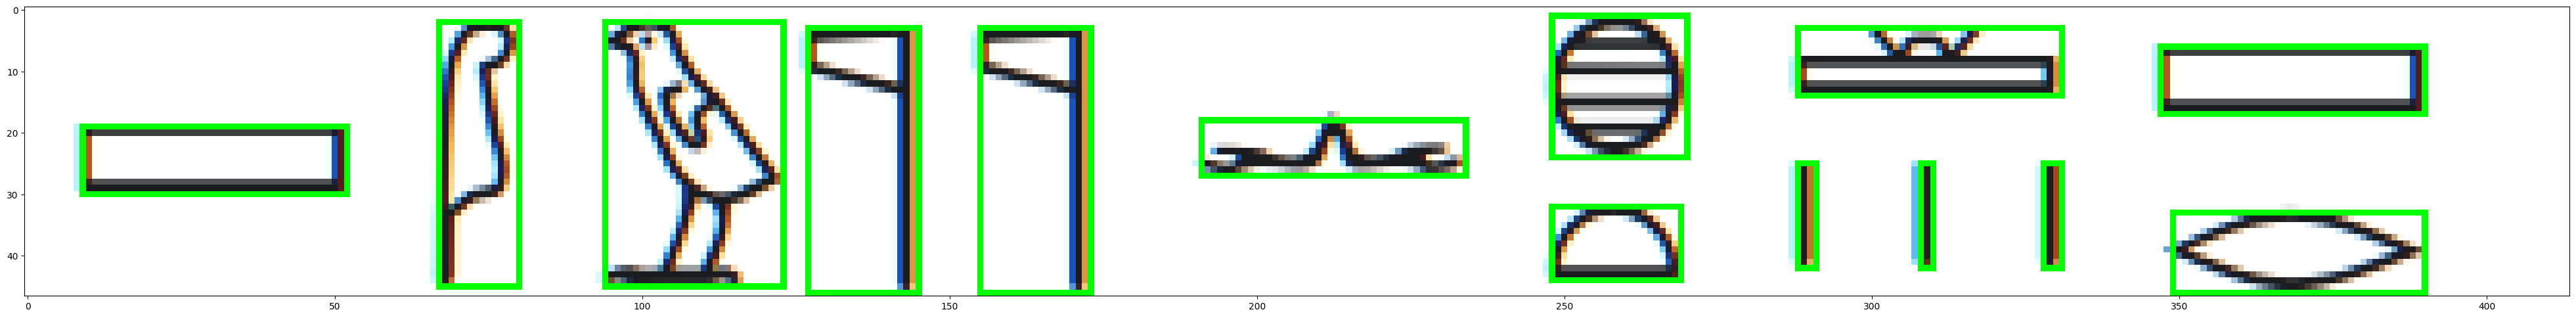

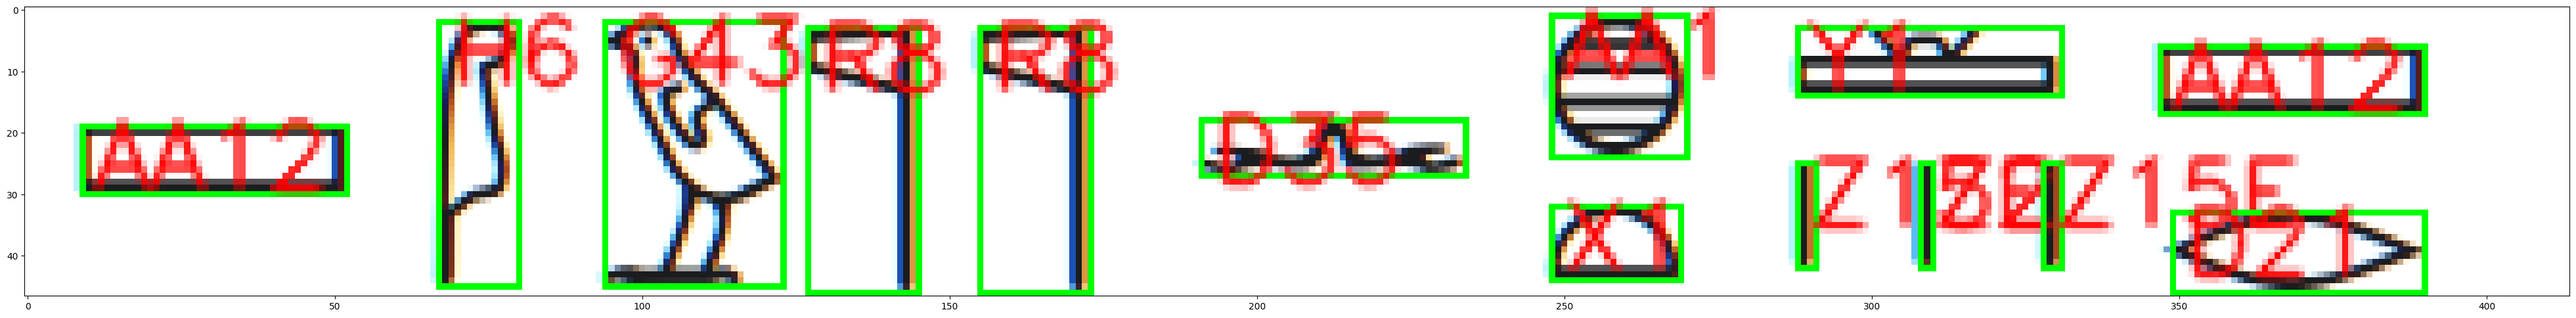

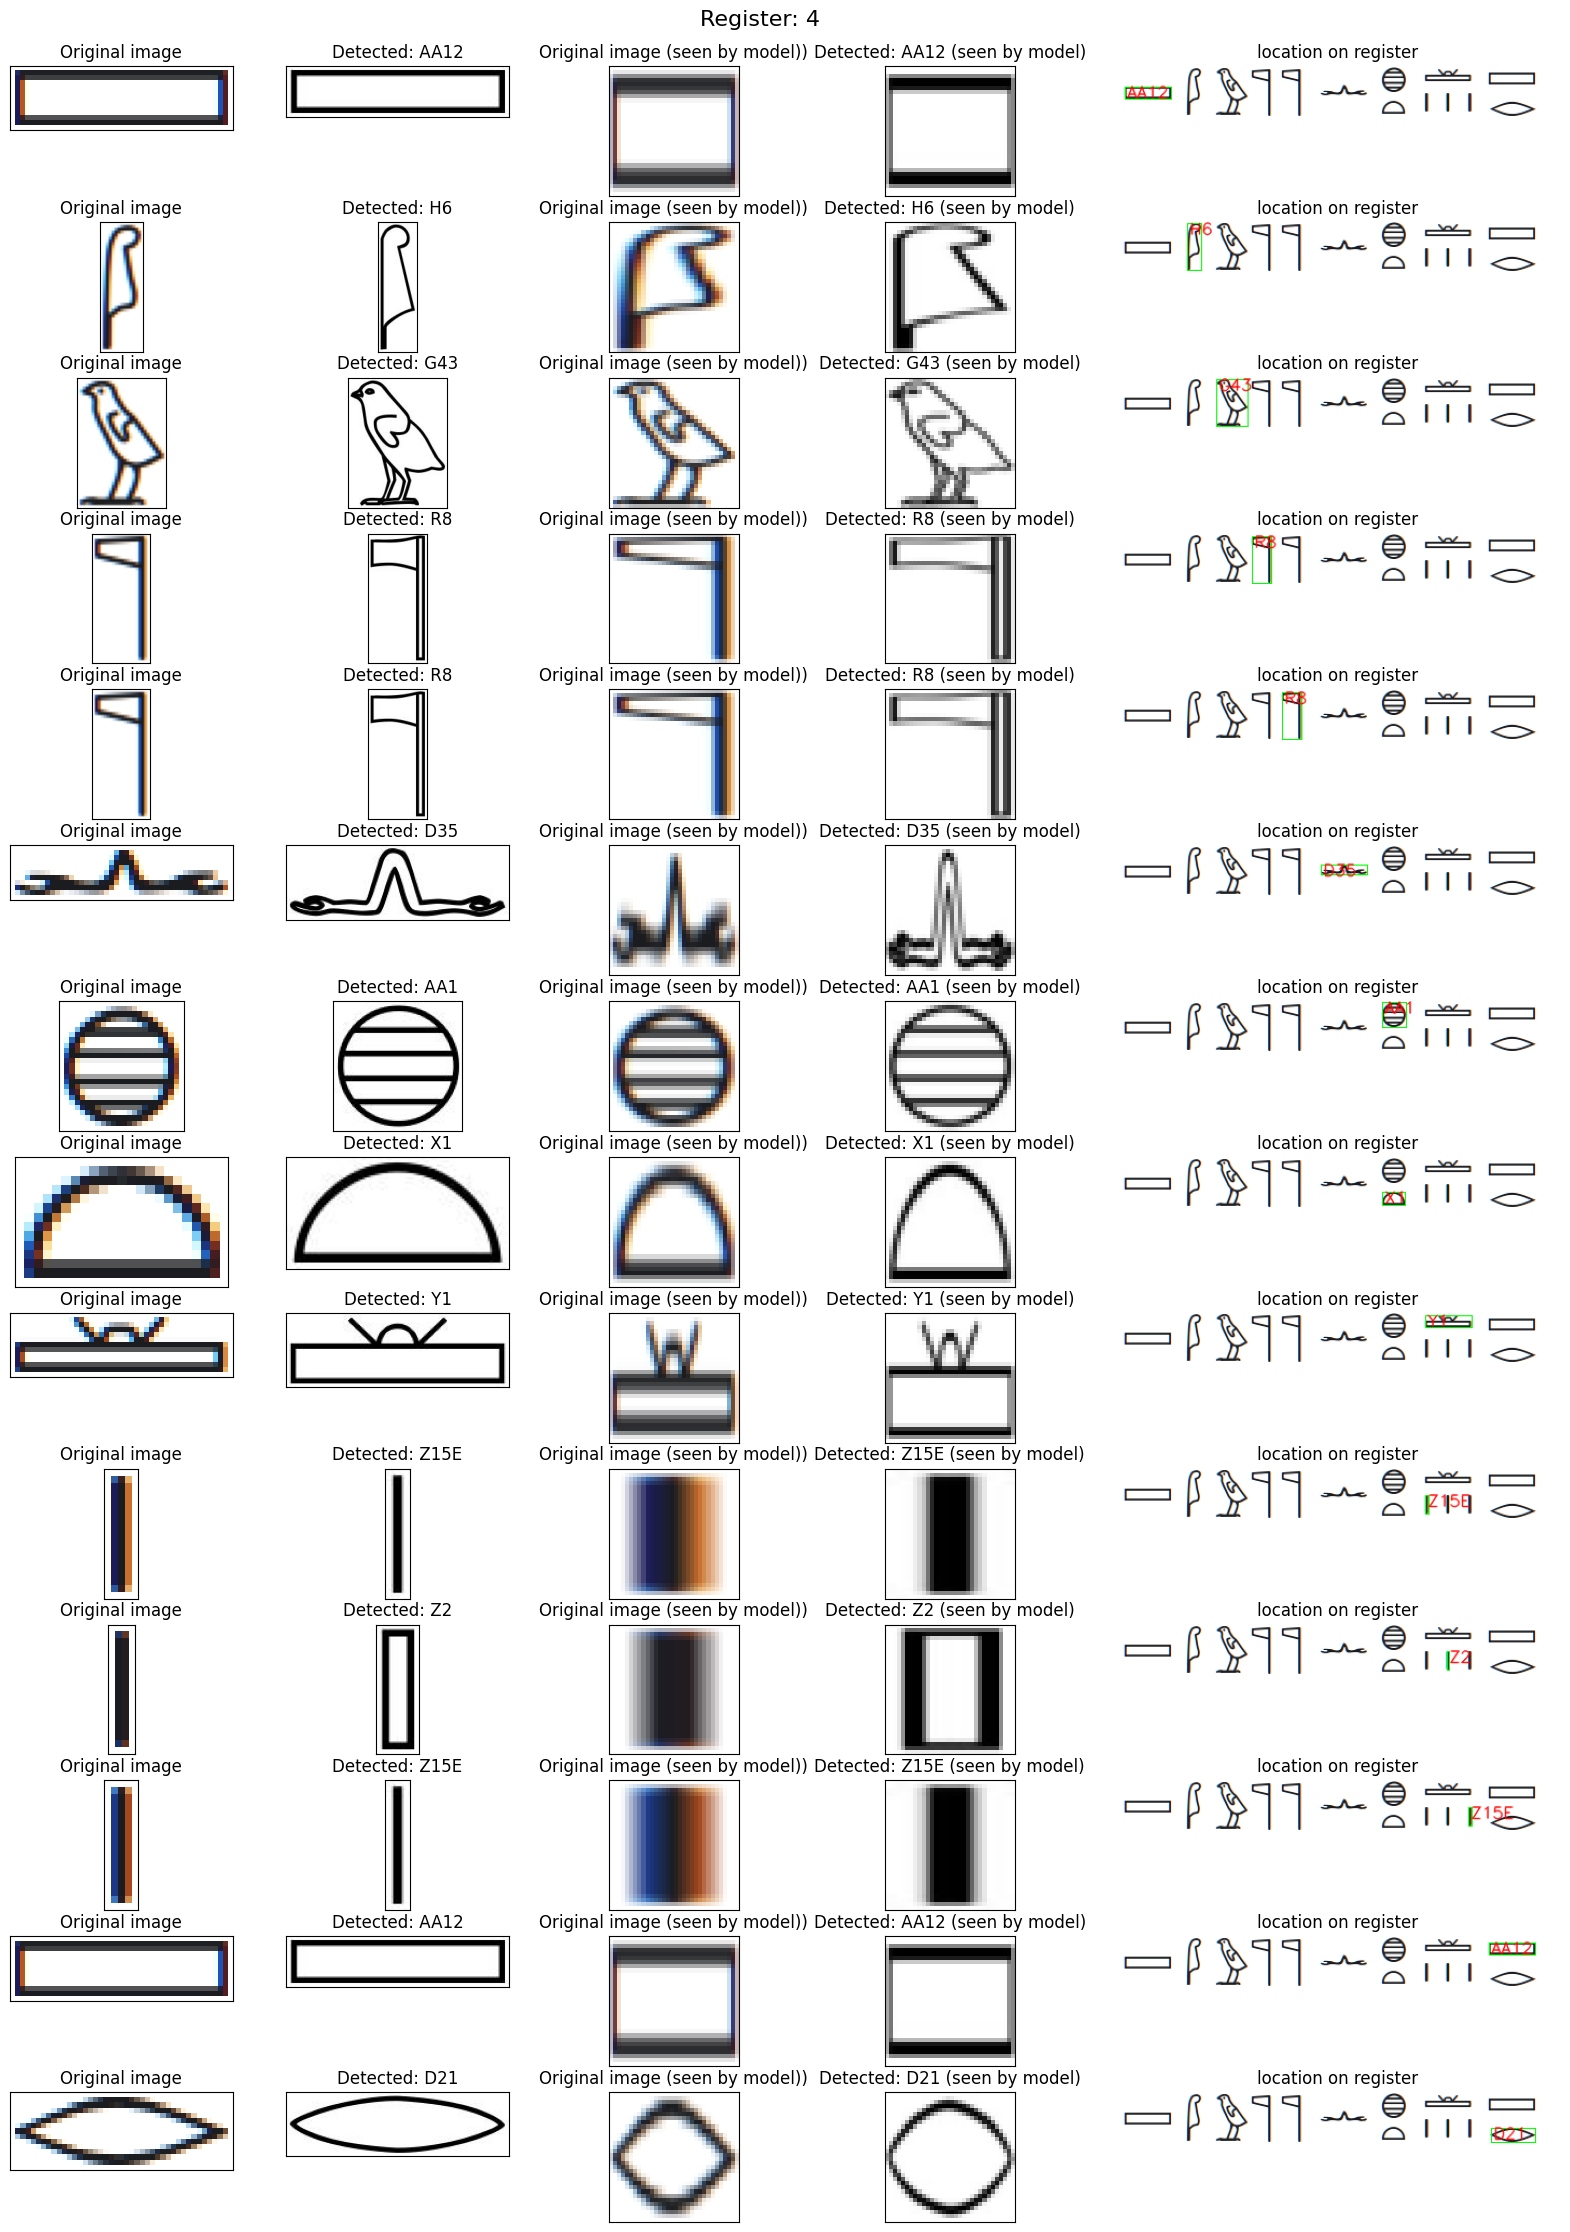

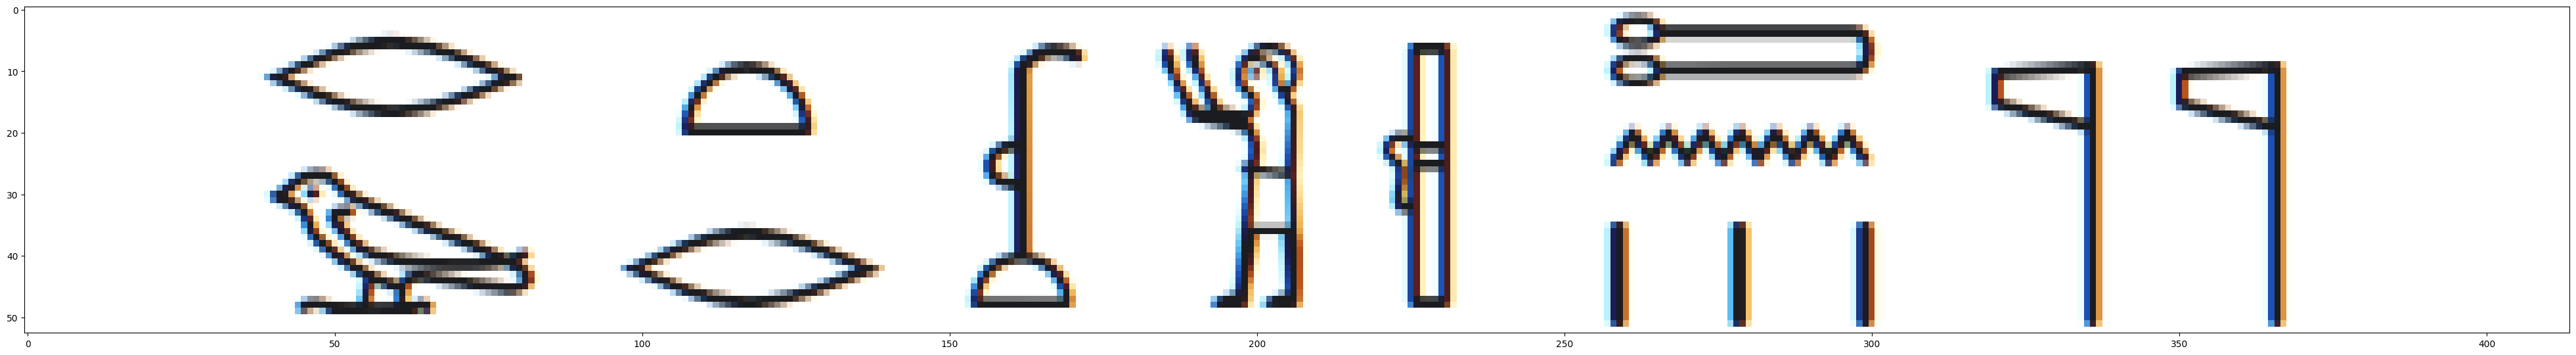

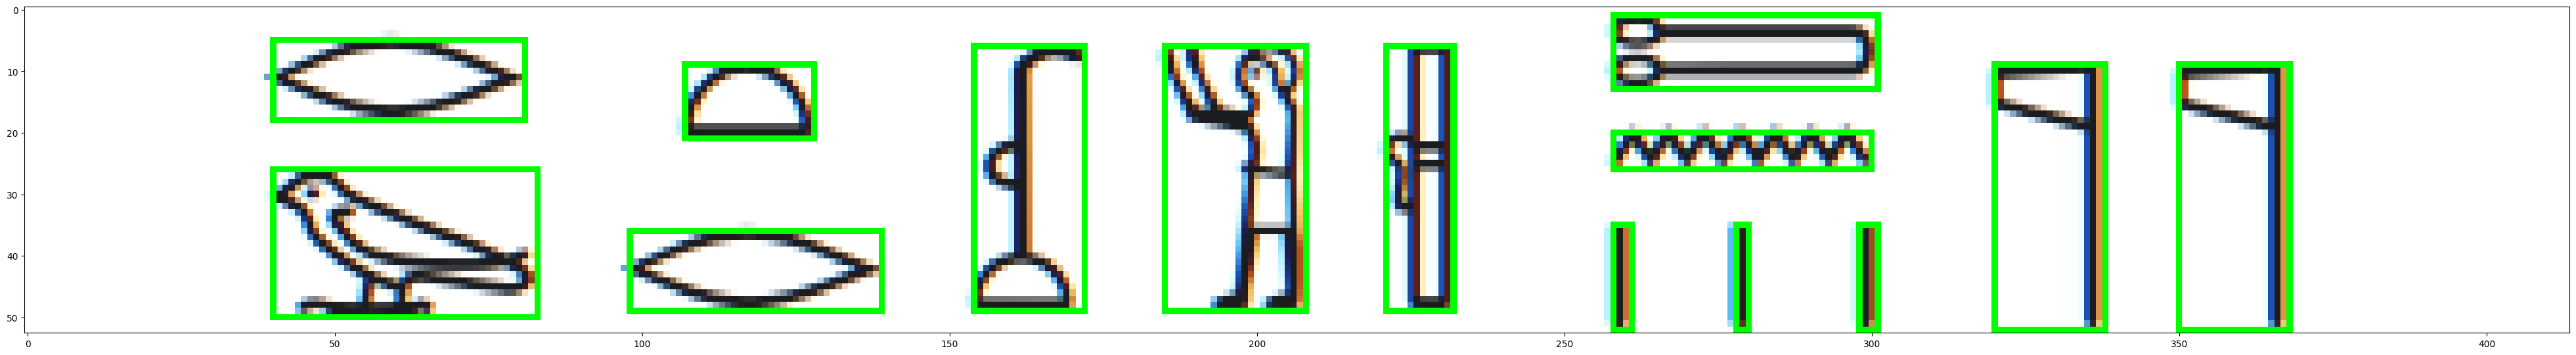

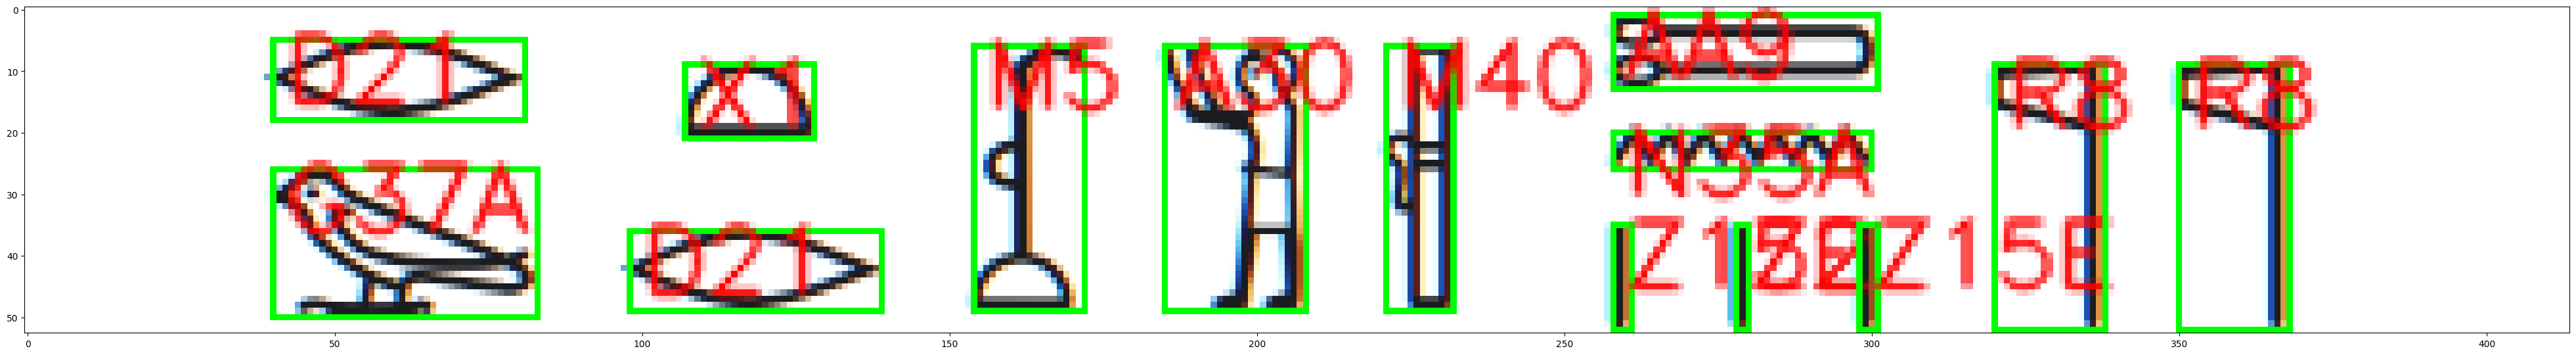

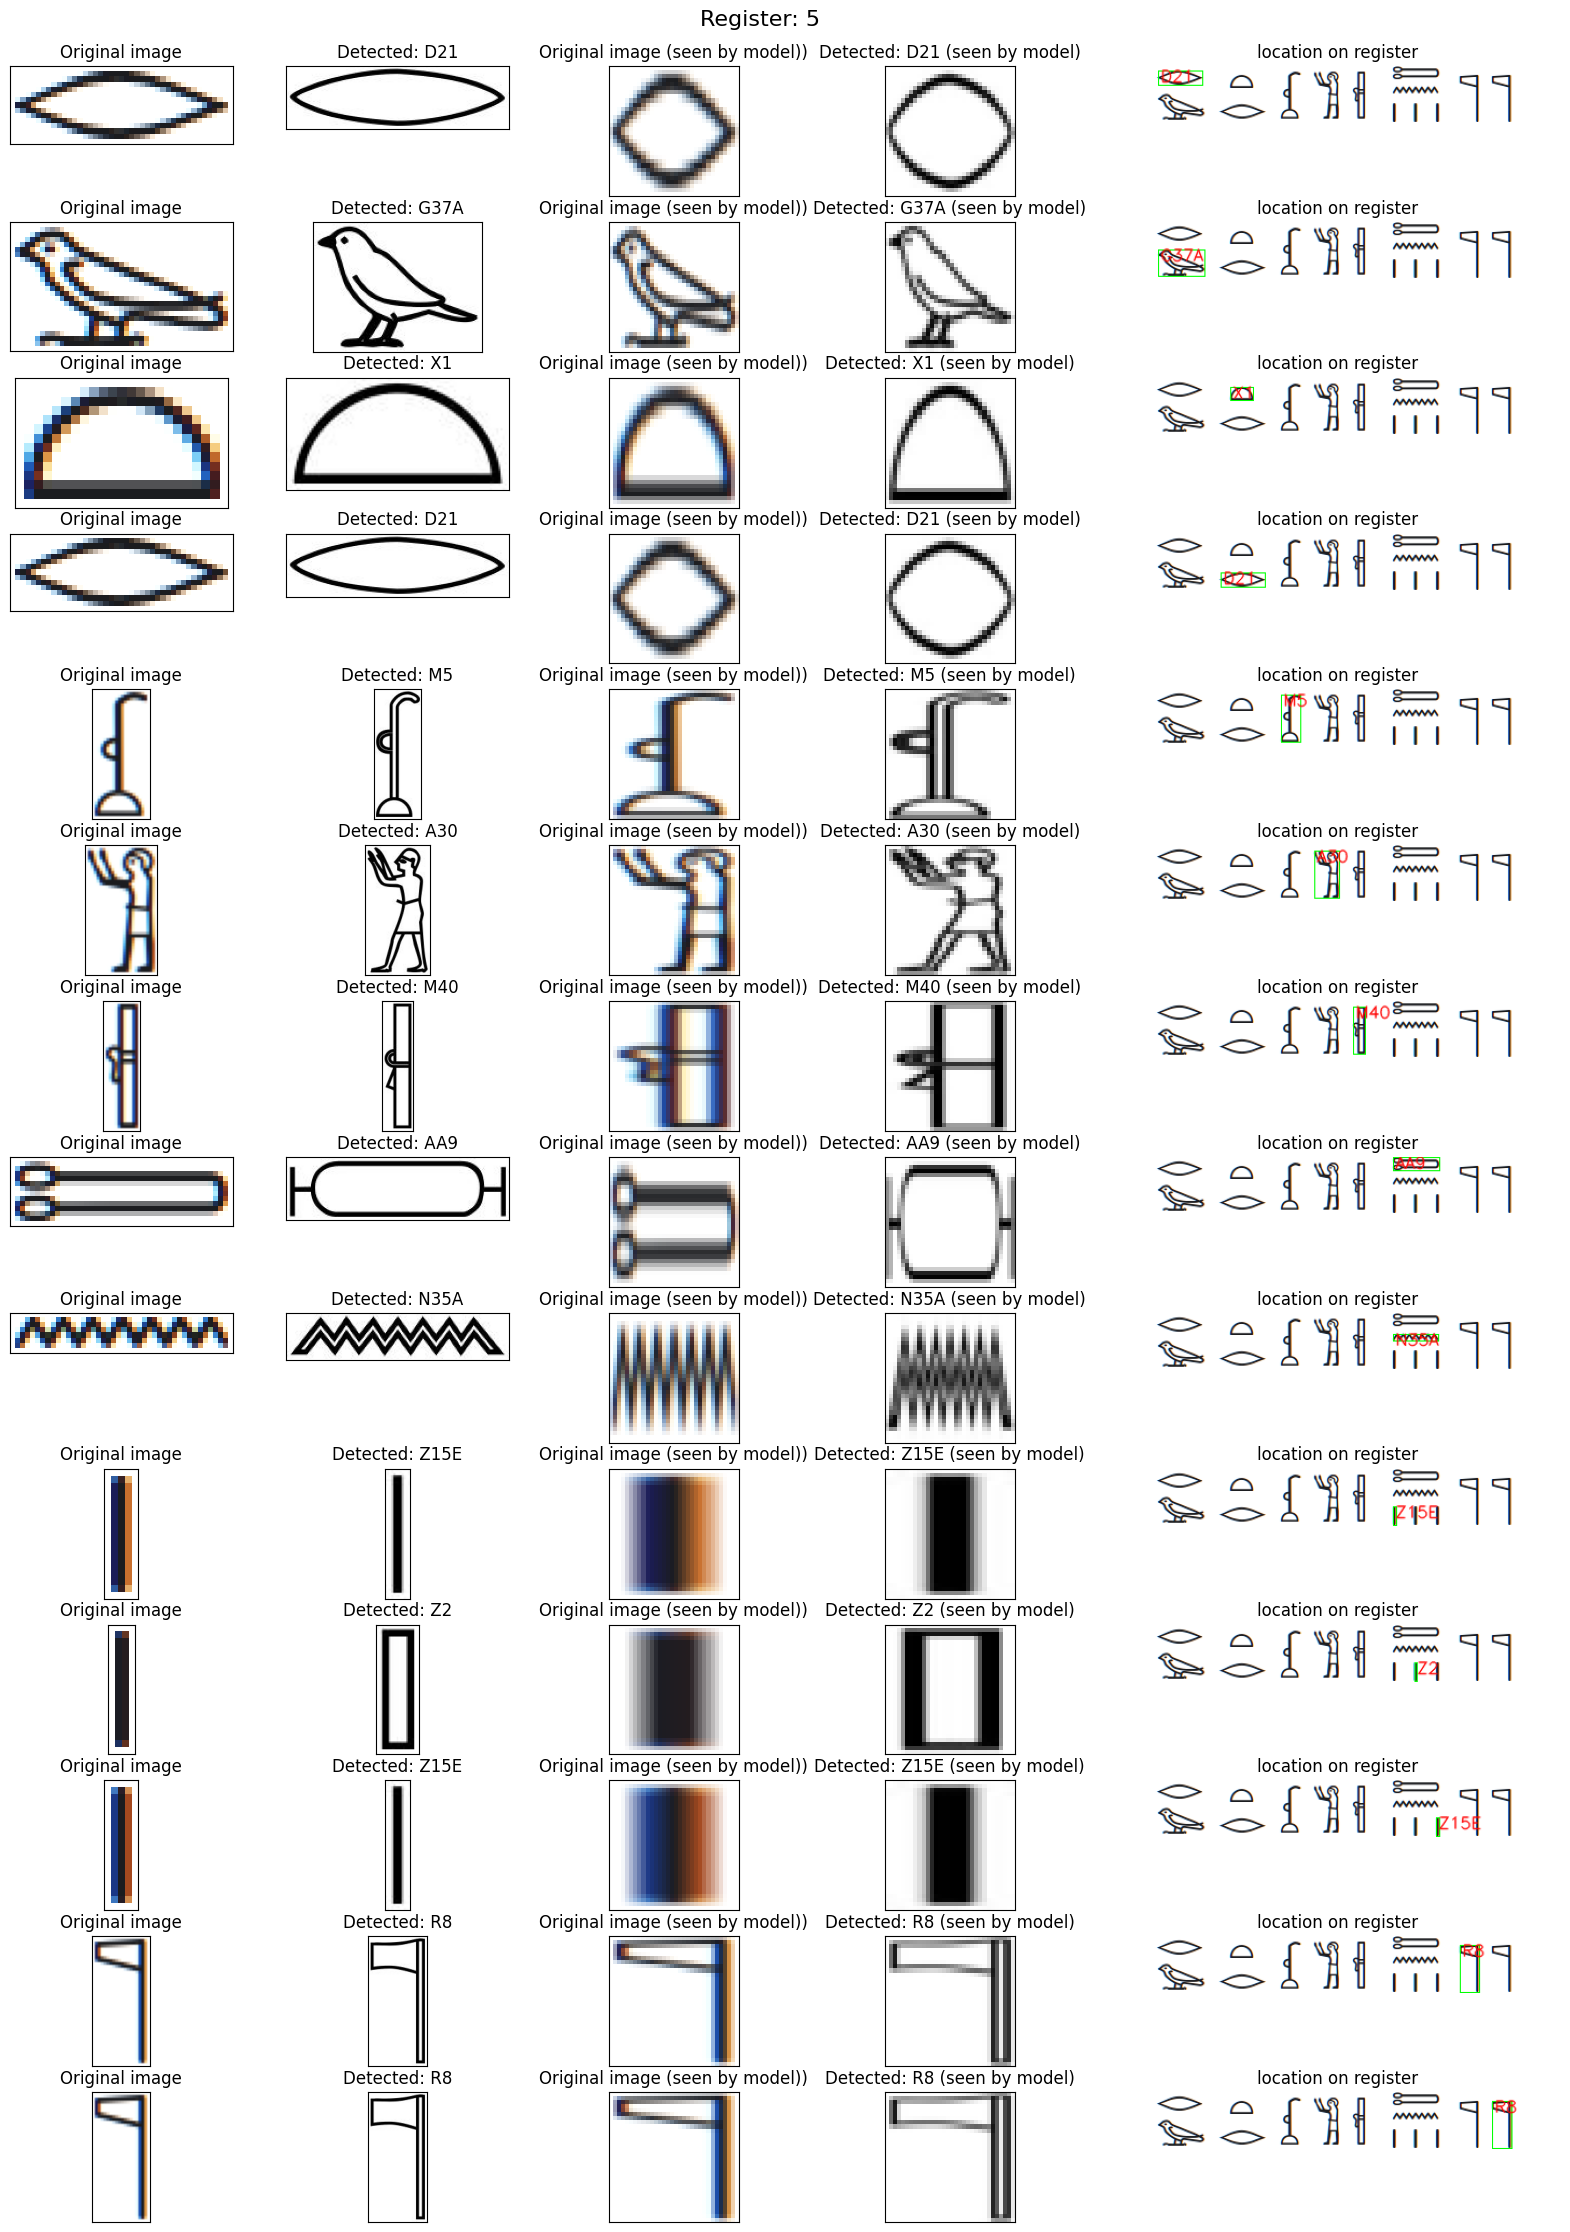

In [3]:
# Print original regsister, register with BBs, register wth bbs and signs, predicted details per sign detected
for file in [os.path.join(test_dir,'1. text.png')]:
    output = []
    # Step 1 - Get the registers in the image
    img_hiero_txt,original_h,original_w  = wj.prep_image(file)
    regs = wj.get_horizontal_registers(img_hiero_txt,original_h,original_w,blur=(1,1) )
    
    # For each register, get the signs
    for idx,reg in enumerate(regs):
        x,y,w,h = reg
        reg_out = []

        crop_img = img_hiero_txt[y:y+h, x:x+w]
        crop_img = cv2.copyMakeBorder(crop_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT,value=[255,255,255])
        reg_img,original_h,original_w  = wj.prep_image(crop_img,False)

        # Get horizontal clusters of signs
        signs_out = wj.get_sign_cluster(reg_img,h)


        # For each sign, get the infered sign and the bounding box
        for idx,sign in enumerate(signs_out):
            # print(sign)
            x0,y0,w0,h0 = sign
            crop_img = reg_img[y0:y0+h0, x0:x0+w0]
            crop_img = cv2.copyMakeBorder(crop_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT,value=[255,255,255])
            ocr_sign = infer.get_sign_from_image(Image.fromarray(np.array(crop_img)))

            # Predicted hieroglyph plus the bounding box of the sign in the coordinates of the register
            reg_out.append([ocr_sign,sign+np.array([x-1,y-1,0,0])])

        output.append([idx,reg,reg_out])
        
    for idx,regs in enumerate(output):
        x,y,w,h = regs[1]
        signs = regs[2]

        # 1/4 : Print original register
        crop_register = img_hiero_txt[y:y+h, x:x+w]
        crop_register = cv2.copyMakeBorder(crop_register, 1, 1, 1, 1, cv2.BORDER_CONSTANT,value=[255,255,255])
        reg_img,original_h,original_w  = wj.prep_image(crop_register,False)

        plt.figure(figsize=(50,50))
        plt.imshow(reg_img)
        plt.show()

        # 2/4 : Print register with BBs
        signs_list = [item[0] for item in signs] # list of signs
        signs_bbs = [item[1] for item in signs]  # list of sign bounding boxes
        signs_bbs = np.array(signs_bbs) - np.array([x-1,y-1,0,0])
        
        wj.print_registers(signs_bbs,reg_img)

        # 3/4 : Print register with BBs and signs
        wj.print_registers(signs_bbs,reg_img,signs_list)

    # 4/4 : Print predicted details per sign detected
        num_hieros = len(signs_list)
        figure, axis = plt.subplots(num_hieros, 5,figsize=(20, num_hieros*2),gridspec_kw={'width_ratios': [1, 1, 1,1,2]})
        figure.suptitle("Register: "+str(idx), fontsize=16, y=0.9)
        for idx,hiero in enumerate(signs_list):
              
            x,y,w,h = signs_bbs[idx]

            hiero_img = reg_img[y:y+h, x:x+w]
            hiero_img = cv2.copyMakeBorder(hiero_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT,value=[255,255,255])
            hiero_img,original_h,original_w  = wj.prep_image(hiero_img,False)            

            template_filename = hiero+'_AbydosB_200_crop.jpg'
            template_file = os.path.join(template_dir,template_filename)
            template_img = Image.open(template_file) 
             
            axis[idx,0].imshow(hiero_img)  
            axis[idx,0].set_title("Original image")
            axis[idx,1].imshow(template_img)
            axis[idx,1].set_title("Detected: "+hiero)
            axis[idx,2].imshow(infer.data_transforms['ocr2'](Image.fromarray(hiero_img)))
            axis[idx,2].set_title("Original image (seen by model))")
            axis[idx,3].imshow(infer.data_transforms['ocr2'](template_img))
            axis[idx,3].set_title("Detected: "+hiero+" (seen by model)")    
            im = wj.print_registers([signs_bbs[idx]],reg_img,[signs_list[idx]],print=False)        
            axis[idx,4].imshow(im)
            axis[idx,4].set_title("location on register")   
            axis[idx,4].axis('off')

        for ax in axis.flat:
            ax.set(xlabel=None, ylabel=None) 
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_anchor('N')              
        plt.show()


In [4]:
print("| Generating image with signs")
signs = [i for sublist in [i[2] for i in [x for x in output]] for i in sublist]
im = wj.print_registers_with_sign(signs,img_hiero_txt)
print("| Done...")

| Generating image with signs


| Done...
